In [2]:
# !pip install '/data/snowflake_ml_python-0.2.3-py3-none-any.whl'
# !pip install refractml
# !pip install matplotlib
# !pip install seaborn
# !pip uninstall pandas -y
# !pip install pandas==1.5.3

In [4]:
import snowflake.connector
import snowflake.snowpark
import snowflake.ml.preprocessing as snowml
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
from snowflake.ml.utils import connection_params
from snowflake.ml.metrics.correlation import correlation
from snowflake.connector.pandas_tools import write_pandas
from snowflake.ml.framework.pipeline import Pipeline
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.ensemble import RandomForestClassifier
from snowflake.ml.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from snowflake.ml.modeling.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import pandas as pd
import configparser
import warnings; warnings.simplefilter('ignore')

# from snowflake.ml.compose import ColumnTransformer
from snowflake.ml.preprocessing import StandardScaler, OneHotEncoder

/tmp/pip_packages/snowflake/connector/options.py:108: UserWarning: You have an incompatible version of 'pyarrow' installed (10.0.1), please install a version that adheres to: 'pyarrow<8.1.0,>=8.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [5]:
config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    "account": f'{config["Snowflake"]["account"]}',
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

connection successful!


In [1]:
table_name = "ATTRITION"
sf_df = session.table(table_name)
sf_df = sf_df.na.drop()
sf_df = sf_df.drop("USER_ID", "JOB_STARTDATE", "JOB_ENDDATE", "SCHOOL_ENDDATE")

NameError: name 'session' is not defined

In [7]:
df = sf_df.to_pandas()
CATEGORICAL_COLUMNS = ["MAPPED_ROLE_CLEAN","SEX", "ETHNICITY","HOSPITAL_TYPE", "HOSPITAL_OWNERSHIP",
                       "COMPANY_NAME","CITY_STATE","DISTANCE", "DEGREE_CLEAN"]
NUMERICAL_COLUMNS = ["SALARY", "SENIORITY", "TENURE_MONTHS", "MONTHS_AFTER_COLLEGE", "BIRTH_YEAR", "OVERTIME_HOURS"]
LABEL_COLUMNS = ["CHURN"]
OUTPUT_COLUMNS = ["PREDICTION"]
train_df, test_df = sf_df.random_split([0.8,0.2], seed=25)

In [8]:
## train_df and test_df are both snowpark dataframes
pipeline = Pipeline(
    steps=[(
                "OE",
                OrdinalEncoder(
                input_cols=CATEGORICAL_COLUMNS,
                output_cols=CATEGORICAL_COLUMNS,
                handle_unknown='use_encoded_value',
                unknown_value=-1
                )),
               ("MMS",
                MinMaxScaler(
                clip=True,
                input_cols=NUMERICAL_COLUMNS,
                output_cols=NUMERICAL_COLUMNS,
                )),
               ("classification",
                XGBClassifier(
                input_cols=CATEGORICAL_COLUMNS+NUMERICAL_COLUMNS,
                label_cols=LABEL_COLUMNS,
                output_cols=OUTPUT_COLUMNS
                ))])

pipeline.fit(train_df) ## fiting the dataset
result = pipeline.predict(test_df) 

In [9]:
from joblib import dump, load
filename = "snowflake_ml_model.joblib"
dump(pipeline, filename)

['snowflake_ml_model.joblib']

In [10]:
model = load(filename)

In [11]:
test = test_df.to_pandas()
train = train_df.to_pandas()
train["CHURN"] = train["CHURN"].apply(lambda x: 1 if x else 0)
pred = model.predict(test)
pred["probabilities"] = model.predict_proba(test)[["predict_proba_True"]]
test["PREDICTION"] = pred["PREDICTION"]
test["probabilities"] = pred["probabilities"]
test["CHURN"] = test["CHURN"].apply(lambda x: 1 if x else 0)

y_prob = np.array(test["probabilities"])
y_test = pred["CHURN"]
y_pred = pred["PREDICTION"]
X_train = train.drop(["CHURN"], axis=1)
X_test = pred.drop(["CHURN", "PREDICTION", "probabilities"], axis=1)
y_train = train["CHURN"]

In [12]:
# old = test.iloc[:400]
# new = test.iloc[400:]
# print(len(old))
# print(len(new))
# old.to_csv("/data/drift_old_data.csv", index=False)
# new.to_csv("/data/drift_new_data.csv", index=False)

In [12]:
from refractml import *
from refractml.constants import MLModelFlavours
import requests

In [13]:
@scoring_func
def score(model, request):
    payload_dict = request.json["payload"]
    data = pd.DataFrame(payload_dict,index=[0])
    prediction = str(model.predict(data)["PREDICTION"][0])
    return prediction

In [14]:
test_data = test_df.to_pandas()

In [1]:
from fosforml import *
from fosforml.constants import MLModelFlavours

/tmp/pip_packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [19]:
payload  = test_data.iloc[0].to_dict()
del payload["CHURN"]
payload

{'SALARY': 62668.834,
 'SENIORITY': 2,
 'TENURE_MONTHS': 8,
 'MONTHS_AFTER_COLLEGE': 106,
 'BIRTH_YEAR': 1981,
 'MAPPED_ROLE_CLEAN': 'nurse',
 'SEX': 'F',
 'ETHNICITY': 'White',
 'HOSPITAL_TYPE': 'Acute Care Hospitals',
 'HOSPITAL_OWNERSHIP': 'Voluntary non-profit - Church',
 'COMPANY_NAME': 'Mayo Clinic',
 'CITY_STATE': 'Rochester, MN',
 'DISTANCE': '5-10mi',
 'DEGREE_CLEAN': 'Masters_Degree',
 'OVERTIME_HOURS': 6}

In [13]:
req = requests.Request()
req.json = {"payload":payload}
y = req
yo = score(model, y)
yo

'0'

In [14]:
data={"payload": payload}

In [15]:
data

{'payload': {'SALARY': 28361.401,
  'SENIORITY': 1,
  'TENURE_MONTHS': 98,
  'MONTHS_AFTER_COLLEGE': 4,
  'BIRTH_YEAR': 1981,
  'MAPPED_ROLE_CLEAN': 'nurse',
  'SEX': 'F',
  'ETHNICITY': 'White',
  'HOSPITAL_TYPE': 'Psychiatric',
  'HOSPITAL_OWNERSHIP': 'Proprietary',
  'COMPANY_NAME': 'Tenet Healthcare Corp.',
  'CITY_STATE': 'Worcester, MA',
  'DISTANCE': '<2mi',
  'DEGREE_CLEAN': 'Bachelors_Degree',
  'OVERTIME_HOURS': 10}}

In [16]:
data["payload"].keys()

dict_keys(['SALARY', 'SENIORITY', 'TENURE_MONTHS', 'MONTHS_AFTER_COLLEGE', 'BIRTH_YEAR', 'MAPPED_ROLE_CLEAN', 'SEX', 'ETHNICITY', 'HOSPITAL_TYPE', 'HOSPITAL_OWNERSHIP', 'COMPANY_NAME', 'CITY_STATE', 'DISTANCE', 'DEGREE_CLEAN', 'OVERTIME_HOURS'])

In [20]:
# headers={"Content-type":"application/json"}
# url = "http://svc-f62b4647-3042-4150-b24d-ee5418001e27:5001/snowflakemlmodel/8d3467c7-892f-45f4-af2c-db5886347d84/score"
# data={"payload": payload}
# response = requests.post(url, json=data, headers=headers) 
# response.json()

{'data': '1', 'request_id': '2c4bcf7b-31c8-4d73-bf0c-81afd858e304'}

In [18]:
## registering the model in refract.
tmp = register_model(model, 
               score, 
               name="Snowflake_ml_model", 
               description="HR ANALYTICS model trained using Snowflake ml",
               flavour=MLModelFlavours.sklearn,
               model_type="classification",
               init_script="pip install '/data/snowflake_ml_python-0.2.3-py3-none-any.whl'",
               y_true=y_test,
               y_pred=y_pred, 
               features=X_train.columns,
               labels=[0,1],
               input_type="json", 
               explain_ai=True,
               prob=y_prob,
               x_train=X_train, 
               x_test=X_test, 
               y_train=y_train.tolist(),
               y_test=y_test.tolist(),
               feature_names=X_train.columns.tolist(),
               original_features=X_train.columns.tolist(),
               feature_ids=X_train.columns,
               target_names=['NOT LEFT','LEFT'],
               kyd=True, kyd_score = True)


Calculating build time metrics

Progress: ██████████████████████████████████████████████████████████████████████ 100.0%


In [13]:
result = pipeline.predict(test_df)
result_prob = pipeline.predict_proba(test_df)
pred_df = test_df.to_pandas()
result = result.to_pandas()
result_prob = result_prob.to_pandas()
pred_df["PREDICTION"] = result["PREDICTION"]
pred_df["PROB"] = result_prob["PREDICT_PROBA_TRUE"]

In [14]:
## scores
from sklearn.metrics import classification_report, log_loss, roc_auc_score
y_test = [1 if i is True else 0 for i in pred_df["CHURN"]]
y_pred = [int(i) for i in pred_df["PREDICTION"]]
print(classification_report(y_test, y_pred))

accuracy = sum([1 if y_test[i] == y_pred[i] else 0 for i in range(len(y_test))]) / len(y_test)
print("accuracy: ", accuracy )

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       526
           1       0.81      0.81      0.81       280

    accuracy                           0.87       806
   macro avg       0.85      0.85      0.85       806
weighted avg       0.87      0.87      0.87       806

accuracy:  0.8660049627791563


In [15]:
log_loss(y_test,pred_df["PROB"] )

0.3189889499673432

In [16]:
roc_auc_score(y_test,pred_df["PROB"])

0.9395810700706138

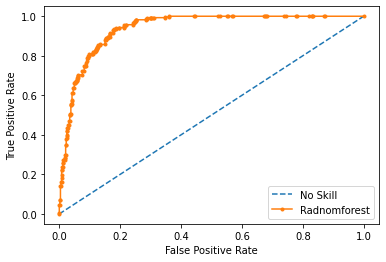

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, pred_df["PROB"])
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_df["PROB"])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Radnomforest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

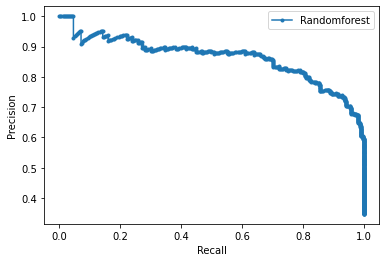

In [18]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pred_df["PROB"])
plt.plot(lr_recall, lr_precision, marker='.', label='Randomforest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

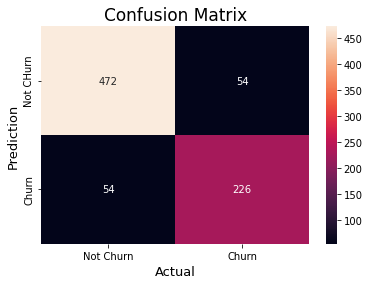

In [19]:
cm = confusion_matrix(y_test,y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not Churn','Churn'],
            yticklabels=['Not CHurn','Churn'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [23]:
scores_data = pd.DataFrame({"ns_probs":ns_probs,
                            "y_test":y_test,
                            "y_pred":pred_df["PREDICTION"],
                            "act_probs":pred_df["PROB"]})

In [24]:
scores_data

,ns_probs,y_test,y_pred,act_probs
0,0,0,1,0.783455
1,0,0,0,0.000034
2,0,0,0,0.000126
3,0,0,0,0.200967
4,0,0,0,0.000051
...,...,...,...,...
801,0,1,1,0.903771
802,0,0,0,0.000354
803,0,0,0,0.000492
804,0,0,0,0.001046


In [25]:
scores_data.to_csv("/data/scores.csv", index=False)

In [ ]:
df = pd.read_csv("/data/HR_analytics_data_scored.csv")